# Clover platform challenge

Background:

* Major need to provide context to care givers
    * e.g. what chronic conditions a patient has
* Often have to infer context due to missing records
* Here, infer patient disease status given prescription data


**Methods:**

* Inspect and prep/clean the data (see [scratch notebook](inspect.ipynb))
* Count things: medication and disease frequency (objectives 1-2)
* Develop simple model using training data (3)
* Tune model using cross-validation (3)
* Assess model performance using test data (4)    
* Extend model (5)


Objectives and **Results**:

1. What are the most common medications for each disease in the base file?
  > 
  * LISINOPRIL and SIMVASTATIN (for high lipids and blood pressure) were the most common drugs among patients with high blood pressure, and were also common among patients with other diseases (since high blood pressure was common overall).  
  * Looking ony at patients with a single disease resulted in a more diverse list of medications common to each disease (e.g. ONETOUCH for diabetes)

1. What medications are most indicative of each disease?
  > 
  * As determined both by Specificity and Precision (positive predictivity), AMLODIPINE, ATENOLOL, and HYDROCHLOROTHIAZIDE were indicative of high blood pressure, while WARFARIN, PLAVIX, and FUROSEMIDE were indicative of stroke.  
  * Ranking drugs by Specificity and Precision seemed to return similar results, however, Precision may be easier to interpret as a measure of "indicative" of disease (Precision = 'probability of a patient having the disease, given that he or she takes the medication')

1. Choose ONE of the diseases and build a model to infer whether that disease is present from the medications.
  > 
  * A logistic regression model was used to predict the occurance of Stroke based on the use or non-use of 45 medications highly indicative of the disease (only medications used by at least 5% of patients with stroke were included).  

1. Demonstrate that the end user should be confident in the result
  > 
  * The model achived ~80% mean accuracy with a true positive rate (sensitivity) of ~65% and a true negative rate (specificity) of 80% on the validation data set.  
  (On average, each of the 45 drugs alone exhibited only 11% sensitivity, but 96% specificity.)  
  * Parameter tuning to maximize sensitivity did not improve results.  
  There was no evidence of overfitting.

1. Bonus: Extend this to other diseases of interest, using
https://dl.dropboxusercontent.com/u/103227113/meps_curated/meps_conditions.csv

1. If you feel like going further: The source data set is meps (http://meps.ahrq.gov/mepsweb/ ). There is a lot more data in there (including medical costs and utilization). Add something you think is interesting. (An FYI: id in the curated dataset corresponds to DUPERSID in the raw files.)


Discussion / Conclusions:  

* It's important to consider co-morbidities when examinining individual diseases--especially common ones like high blood pressure
* Specificity and Precision (Positive Predictivity) can be used as measures for how "indicative" a medication is of a particular disease.
* Using many medications rather than a single one can be a more sensitive approach for predicting whather an individual has a diease such as Stroke.

Requirements / checklist:
* confident in results
* readable code
* reuseable code
* reusable data
* data quality, e.g. duplicates
* sanity check using other sources
* interpretation of model performance

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from source.helpers import COLS_DX, load_base_data, load_meds_data

/home/main/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [102]:
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV

In [2]:
%matplotlib inline

Base data

In [3]:
print load_base_data.__doc__ ####### will want to reuse and improve on this

load and prep base data for patients

    - remap diagnoses:
        yes -> True
        no -> False
        ['Inapplicable', 'DK', 'Refused', 'not ascertained'] -> NaN
    - exclude minors by default
    


In [4]:
df_base = load_base_data()
print len(df_base)
df_base.head()

42324


,panel,pooledWeight,age,sex,race,married,highBPDiagnosed,diabetesDiagnosed,chdDiagnosed,miDiagnosed,anginaDiagnosed,strokeDiagnosed,emphysemaDiagnosed,asthmaDiagnosed,otherHDDiagnosed,heartFailureDiagnosed
id,,,,,,,,,,,,,,,,
10007101,15,3603.881236,28,Male,White,MARRIED,True,False,False,False,False,False,False,False,False,False
10007102,15,2544.550424,25,Female,White,MARRIED,False,False,False,False,False,False,False,True,False,False
10008101,15,3635.552466,51,Male,Multiple,MARRIED,False,False,False,False,False,False,False,False,False,False
10008102,15,4367.816253,53,Female,Asian,MARRIED,False,False,False,False,False,False,False,False,False,False
10009101,15,6241.938280,61,Female,Black,NEVER MARRIED,True,False,False,False,False,False,False,False,False,False


(from other [notebook](#inspect.ipynb))
> data prep summary 
* looks like one row per patient
* could potentially have some duplicates (<1%)
* not sure what `panel` or `pooledWeight` mean
* Threw out diagnoses besides Yes / No
* option to throw out data from minors (lots of "Inapplicable" values)

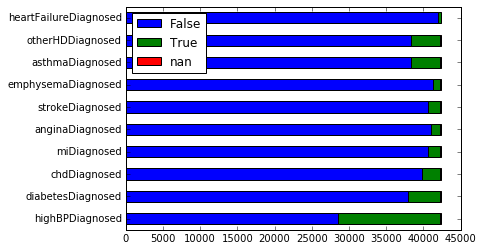

In [5]:
df_base[COLS_DX].apply(lambda ds: ds.value_counts(dropna=False)).T.plot.barh(stacked=True);

> lots of high blood pressure

### meds

In [6]:
print load_meds_data.__doc__

load and prep meds data

    - disambiguate drug names
    - collapse duplicate prescriptions per patient
    


In [7]:
df_meds = load_meds_data()
df_meds.head()

numPrescriptions                originalNDCs
id       rxNickname                                                
10007101 ATENOLOL                     4  [68382002210, 51079068463]
         AZITHROMYCIN                 1               [59762314001]
10007102 CARISOPRODOL                 1                 [603258228]
         HYDROCO                      1                 [406036005]
         TREXIMET                     2                 [173075000]

(from other [notebook](#inspect.ipynb))
> data prep summary
* looks like 1 row per prescription
* lots of ambigous drug names and NDCs, even per-patient
* drug nickname: 1st word in drug name
* collapsed data into unique drug nicknames per patient
    * keep original NDCs
    * count number of prescriptions per drug per patient in case useful

## What are the most common medications for each disease in the base file?
Could interpret as:
1. Among all patients with a specific disease, which meds are most common?  
(but could be confounded by other diseases)
2. Among patietns with _only_ a specific disease, which meds are most common?  
(maybe better?)

In [8]:
df = pd.merge(df_base.reset_index(), 
              df_meds.reset_index(), 
              how='inner',   # ignore patients without drugs
              left_on='id', 
              right_on='id')

In [9]:
print df.id.nunique(), 'patients'
print df.rxNickname.nunique(), 'drugs'
df.head(2)

30856 patients
3290 drugs


,id,panel,pooledWeight,age,sex,race,married,highBPDiagnosed,diabetesDiagnosed,chdDiagnosed,miDiagnosed,anginaDiagnosed,strokeDiagnosed,emphysemaDiagnosed,asthmaDiagnosed,otherHDDiagnosed,heartFailureDiagnosed,rxNickname,numPrescriptions,originalNDCs
0,10007101,15,3603.881236,28,Male,White,MARRIED,True,False,False,False,False,False,False,False,False,False,ATENOLOL,4,"[68382002210, 51079068463]"
1,10007101,15,3603.881236,28,Male,White,MARRIED,True,False,False,False,False,False,False,False,False,False,AZITHROMYCIN,1,[59762314001]


### 1)
Rank meds by $P(M|D_i)$ for each disease $D_i$

e.g. high blood pressure

In [10]:
df[df.highBPDiagnosed == True].rxNickname.value_counts().head(3)

LISINOPRIL             3104
SIMVASTATIN            2418
HYDROCHLOROTHIAZIDE    1976
Name: rxNickname, dtype: int64

> Makes sense. Drugs for high lipids and blood pressure.

In [11]:
n_top = 3

In [35]:
for dx in COLS_DX:
    has_disease = df[dx] == True
    cts = df[has_disease].rxNickname.value_counts()

    n_diagnosed = df.loc[has_disease, 'id'].nunique()

    print dx
    print cts.head(n_top).to_string()
    print 'of', n_diagnosed, 'patients diagnosed'
    print

highBPDiagnosed
LISINOPRIL             3104
SIMVASTATIN            2418
HYDROCHLOROTHIAZIDE    1976
of 12626 patients diagnosed

diabetesDiagnosed
METFORMIN      2156
LISINOPRIL     1251
SIMVASTATIN    1119
of 4207 patients diagnosed

chdDiagnosed
METOPROLOL     689
SIMVASTATIN    671
LISINOPRIL     615
of 2250 patients diagnosed

miDiagnosed
METOPROLOL     477
SIMVASTATIN    460
LISINOPRIL     446
of 1468 patients diagnosed

anginaDiagnosed
METOPROLOL     337
SIMVASTATIN    299
LISINOPRIL     274
of 1098 patients diagnosed

strokeDiagnosed
SIMVASTATIN    425
LISINOPRIL     383
PLAVIX         314
of 1485 patients diagnosed

emphysemaDiagnosed
ALBUTEROL     240
ADVAIR        193
LISINOPRIL    187
of 874 patients diagnosed

asthmaDiagnosed
ALBUTEROL       726
AZITHROMYCIN    672
ADVAIR          639
of 3432 patients diagnosed

otherHDDiagnosed
LISINOPRIL     757
METOPROLOL     752
SIMVASTATIN    738
of 3629 patients diagnosed

heartFailureDiagnosed
FUROSEMIDE    239
LISINOPRIL    158
CARV

In [36]:
100. * cts.head(n_top) / n_diagnosed

FUROSEMIDE    56.904762
LISINOPRIL    37.619048
CARVEDILOL    27.857143
Name: rxNickname, dtype: float64

> SIMVASTATIN and LISINOPRIL very common. Looks like high blood pressure comes along for the ride

### 2)
Rank meds by $P(M|D_i \cap \not D_k)$ for each disease $D_i$ and all other diseases $D_k, k \ne i$

In [32]:
def top_cts_pcts(cts, n_tot, n_top=n_top):
    pct = (100. * cts / n_tot).apply(lambda x: '{:.2f}%'.format(x))
    ds = cts.head(n_top).astype(str) + ' (' + pct.head(n_top).astype(str) + ')'
    return ds.to_string()

In [33]:
for dx in COLS_DX:
    has_disease = df[dx] == True
    not_others = (df[COLS_DX].drop(dx, axis=1) == False).all(1)
    cts = df[has_disease & not_others].rxNickname.value_counts()

    n_diagnosed = df.loc[has_disease & not_others, 'id'].nunique()

    print dx
    print top_cts_pcts(cts, n_diagnosed)
    print 'of', n_diagnosed, 'patients diagnosed with only this disease'
    print

highBPDiagnosed
LISINOPRIL             1148 (19.54%)
HYDROCHLOROTHIAZIDE     912 (15.52%)
AMLODIPINE              766 (13.04%)
of 5875 patients diagnosed with only this disease

diabetesDiagnosed
METFORMIN     419 (54.63%)
ONETOUCH      155 (20.21%)
LISINOPRIL    145 (18.90%)
of 767 patients diagnosed with only this disease

chdDiagnosed
SIMVASTATIN    13 (20.00%)
METOPROLOL     13 (20.00%)
APAP            9 (13.85%)
of 65 patients diagnosed with only this disease

miDiagnosed
METOPROLOL     8 (22.86%)
HYDROCO        7 (20.00%)
SIMVASTATIN    6 (17.14%)
of 35 patients diagnosed with only this disease

anginaDiagnosed
AZITHROMYCIN    8 (23.53%)
AMOXICILLIN     4 (11.76%)
APAP             3 (8.82%)
of 34 patients diagnosed with only this disease

strokeDiagnosed
SIMVASTATIN     24 (17.39%)
AZITHROMYCIN    22 (15.94%)
AMOXICILLIN     17 (12.32%)
of 138 patients diagnosed with only this disease

emphysemaDiagnosed
SPIRIVA      19 (22.09%)
ADVAIR       17 (19.77%)
ALBUTEROL    12 (13.95%)
o

> ONETOUCH now shows up in top 3 drugs for Diabetes-only patients, which makes sense

## What medications are most indicative of each disease?
"Indicative" is tricky. Could interpret as:
1. drugs that are rarely taken when the disease is not present (high specificity)
2. drugs for which the diseases is common among those who take the drug (high positive predictivity)

### 1)
Rank meds by $P(\not M|\not D_i)$ for each disease.  

Also, exclude drugs used by less than 10% of patients with disease

In [15]:
# n_common = 50 #150
qile_drug = 0.1 # to exclude rare drugs that won't be very useful

In [37]:
for dx in COLS_DX:
    has_disease = df[dx] == True
    cts = df[has_disease].rxNickname.value_counts()
    
    # subset of common meds most-infreqently found in patients without the disease
#    common_meds = cts.head(n_common).index

    n_diagnosed = df.loc[has_disease, 'id'].nunique()
    _thresh = n_diagnosed * qile_drug
    common_meds = cts[cts >= _thresh].index
    cts2 = df[~has_disease].rxNickname.value_counts()[common_meds].sort_values()

    print dx, '(NEGATIVE)'
    print top_cts_pcts(cts2, n_diagnosed)
    print 'of', cts2.sum(), 'patients diagnosed (NEGATIVE)'
    print

highBPDiagnosed (NEGATIVE)
AMLODIPINE             109 (0.86%)
ATENOLOL               163 (1.29%)
HYDROCHLOROTHIAZIDE    200 (1.58%)
of 6419 patients diagnosed (NEGATIVE)

diabetesDiagnosed (NEGATIVE)
HUMULIN    12 (0.29%)
NOVOLIN    16 (0.38%)
LANTUS     17 (0.40%)
of 17537 patients diagnosed (NEGATIVE)

chdDiagnosed (NEGATIVE)
CARVEDILOL    321 (14.27%)
PLAVIX        448 (19.91%)
WARFARIN      451 (20.04%)
of 24060 patients diagnosed (NEGATIVE)

miDiagnosed (NEGATIVE)
CARVEDILOL    417 (28.41%)
METOPROL      479 (32.63%)
WARFARIN      572 (38.96%)
of 26542 patients diagnosed (NEGATIVE)

anginaDiagnosed (NEGATIVE)
WARFARIN    623 (56.74%)
PLAVIX      700 (63.75%)
ASPIRIN     738 (67.21%)
of 30965 patients diagnosed (NEGATIVE)

strokeDiagnosed (NEGATIVE)
WARFARIN       564 (37.98%)
PLAVIX         658 (44.31%)
FUROSEMIDE    1132 (76.23%)
of 29583 patients diagnosed (NEGATIVE)

emphysemaDiagnosed (NEGATIVE)
SPIRIVA    145 (16.59%)
PROAIR     699 (79.98%)
ADVAIR     750 (85.81%)
of 33125 p

> 
* seems to be pretty specific (e.g. HUMALIN, NOVOLIN, LANTUS for diabetes)
* however, the result depends on the size of the subset of common drugs
    * ~~the ideal size of the subset `n_common` probably depends on the drug~~
    * better to just select a percentile

### 2)
Rank meds by $PPV = P(D_i|M)$, the probability of a patient having the disease, given that he or she takes medication

In [38]:
# use Bayes as a trick since we already have P(M|D) 
# (instead of iterating over all drugs for each disease)

for dx in COLS_DX:
    has_disease = df[dx] == True
    cts = df[has_disease].rxNickname.value_counts()
    
    # subset of common meds
    n_diagnosed = df.loc[has_disease, 'id'].nunique()
    _thresh = n_diagnosed * qile_drug
    common_meds = cts[cts >= _thresh].index
  
    # bayes: P(D|M) = P(D)P(M|D)/P(M)
    p_m_d = 100. * cts / cts.sum()  # not len(has_disease) otherwise we may be underestimating??
    cts2 = df.rxNickname.value_counts()
    p_m = (100. * cts2 / cts2.sum())
    p_d = 100. * has_disease.sum() / has_disease.count()
    p_d_m = p_m_d * p_d / p_m
    
    print dx, '(% chance given medication:)'
    print p_d_m.dropna()[common_meds].sort_values(ascending=False).head(n_top).to_string() # limit to common medications for the disease

    print

highBPDiagnosed (% chance given medication:)
AMLODIPINE             94.677734
HYDROCHLOROTHIAZIDE    90.808824
ATENOLOL               89.311475

diabetesDiagnosed (% chance given medication:)
HUMULIN    97.879859
NOVOLIN    96.981132
LANTUS     96.711799

chdDiagnosed (% chance given medication:)
PLAVIX        53.909465
CARVEDILOL    48.058252
WARFARIN      38.639456

miDiagnosed (% chance given medication:)
PLAVIX        40.740741
CARVEDILOL    32.524272
FUROSEMIDE    25.473684

anginaDiagnosed (% chance given medication:)
PLAVIX        27.983539
FUROSEMIDE    17.333333
METOPROLOL    16.535819

strokeDiagnosed (% chance given medication:)
PLAVIX        32.304527
WARFARIN      23.265306
FUROSEMIDE    20.561404

emphysemaDiagnosed (% chance given medication:)
SPIRIVA      55.657492
ALBUTEROL    21.164021
ADVAIR       20.466596

asthmaDiagnosed (% chance given medication:)
ADVAIR       67.762460
ALBUTEROL    64.021164
PROAIR       62.238622

otherHDDiagnosed (% chance given medication:)


In [39]:
# check results
print 100. * df[df.rxNickname == 'AMLODIPINE'].highBPDiagnosed.mean()
print 100. * df[df.rxNickname == 'PLAVIX'].strokeDiagnosed.mean()

94.8166259169
32.3711340206


> 
* results look similar
* interpretation of P(D|M) is easier to understand

In [40]:
#### we'll use again
def proba_dx_rx(dx, qile_drug=None):
    '''probability of disease (dx) given drug (rx)'''
    has_disease = df[dx] == True
    cts = df.loc[has_disease].rxNickname.value_counts()
 
    # subset of common meds
    if qile_drug:
        n_diagnosed = df.loc[has_disease, 'id'].nunique()
        _thresh = n_diagnosed * qile_drug
        common_meds = cts[cts >= _thresh].index
    
    # bayes: P(D|M) = P(D)P(M|D)/P(M)
    p_m_d = 100. * cts / cts.sum()  # not len(has_disease) otherwise we may be underestimating??
    cts2 = df.rxNickname.value_counts()
    p_m = (100. * cts2 / cts2.sum())
    p_d = 100. * has_disease.sum() / has_disease.count()
    p_d_m = p_m_d * p_d / p_m
    
    if qile_drug:
        return p_d_m[common_meds].sort_values(ascending=False)
    
    return p_d_m.sort_values(ascending=False)

## Build a model to infer whether that disease is present from the medications
Now let's use a combination of medications (instead of each medication individually) to predict whether a disease is present.

Diabetes looks like it would be the easiest to predict, based on the previous result.  
Let's try stroke instead, since it looks harder, but is still somewhat distnct (in contrast to heart attack / heart failure?)

### develop model
* create labels and features for each patient
* apply logistic regression

In [41]:
dx = 'strokeDiagnosed'

labels

In [69]:
y = df_base[dx].dropna().astype(int)
100. * y.value_counts(dropna=False) / len(y)

0    96.320793
1     3.679207
Name: strokeDiagnosed, dtype: float64

> 
* droped nans for modeling
* mappped true/false -> 0/1
* _warning:_ heavily unbalanced classes. Would get >90% accuracy by guessing "No"

feautres  
let's use the most indicative drugs for stroke (that are used by at least 5% of the stroke population) as our features

In [65]:
feature_drugs = proba_dx_rx(dx, 0.05).index.tolist()
print len(feature_drugs), 'drugs'
print feature_drugs

45 drugs
['PLAVIX', 'WARFARIN', 'DIGOXIN', 'FUROSEMIDE', 'CARVEDILOL', 'HUMULIN', 'NOVOLIN', 'TRUETRACK', 'LANTUS', 'KLOR', 'INSULIN', 'POTASSIUM', 'ASPIRIN', 'METOPROL', 'METOPROLOL', 'GABAPENTIN', 'AMLODIPINE', 'GLYBURIDE', 'GLIPIZIDE', 'SIMVASTATIN', 'LISINOPRIL', 'PRAVASTATIN', 'ONETOUCH', 'ATENOLOL', 'OMEPRAZOLE', 'LIPITOR', 'TRAMADOL', 'CRESTOR', 'CITALOPRAM', 'ALBUTEROL', 'HYDROCHLOROTHIAZIDE', 'SERTRALINE', 'LEVOTHYROXINE', 'HYDROCHLOROT', 'NEXIUM', 'DIOVAN', 'LEVOTHYROXIN', 'METFORMIN', 'ACETAMINOPHEN', 'APAP', 'HYDROCO', 'PREDNISONE', 'AZITHROMYCIN', 'AMOXICILLIN', 'IBUPROFEN']


In [94]:
has_drug = df_meds.loc[(y.index, feature_drugs), 'numPrescriptions'].unstack() > 0   # why so slow???
X = has_drug.astype(int)
print len(X), 'patients in dataset'
X.head(2)

23118 patients in dataset


rxNickname,ACETAMINOPHEN,ALBUTEROL,AMLODIPINE,AMOXICILLIN,APAP,ASPIRIN,ATENOLOL,AZITHROMYCIN,CARVEDILOL,CITALOPRAM,...,ONETOUCH,PLAVIX,POTASSIUM,PRAVASTATIN,PREDNISONE,SERTRALINE,SIMVASTATIN,TRAMADOL,TRUETRACK,WARFARIN
id,,,,,,,,,,,,,,,,,,,,,
10007101,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
10007102,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [90]:
# print len(y)
# print len(X)

In [95]:
# drop any labels not in x
y = y[X.index]

check: what's the predictive value of each of these drugs individually?

on average for the most indicative drugs:
sensitivity    10.533683
specificity    94.145348


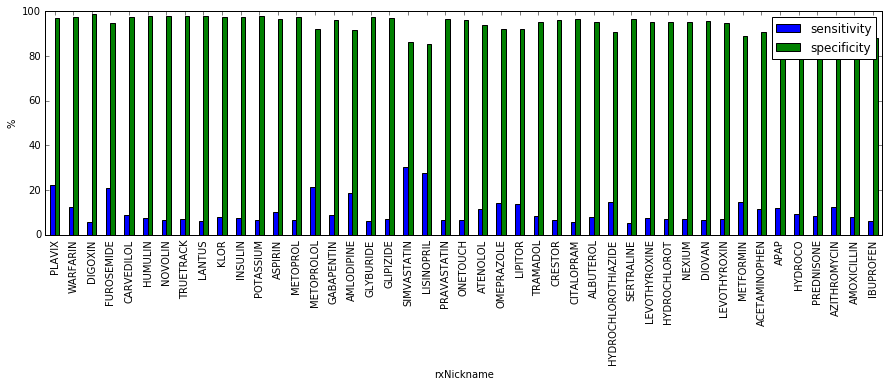

In [109]:
sn_sp = (100. * pd.DataFrame({
    'sensitivity': X[y==True].mean(),
    'specificity': 1. - X[y==False].mean()       
    }))

sn_sp.loc[feature_drugs].plot.bar(figsize=(15, 4));
plt.ylabel('%');

print 'on average for the most indicative drugs:'
print sn_sp.mean().to_string()

> Let's see if we can have better than 11% sensitivity now that we'll be combining drugs into a feature vector

split data into training and test sets

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [111]:
X_train0, X_test0, y_train0, y_test0 = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [112]:
# weight by inverse sample frequency
weights = (len(y) / (y.value_counts())).to_dict()

In [113]:
est = LogisticRegression(class_weight=weights) # we'll do cross validation for other params later
est.fit(X_train0, y_train0)

LogisticRegression(C=1.0,
          class_weight={0: 1.0643156392431288, 1: 16.548317823908373},
          dual=False, fit_intercept=True, intercept_scaling=1,
          max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2',
          random_state=None, solver='liblinear', tol=0.0001, verbose=0,
          warm_start=False)

In [114]:
est.score(X_train0, y_train0) # mean accuracy

0.79335537952780133

In [115]:
est.score(X_test0, y_test0) # mean accuracy

0.7937716262975778

In [116]:
print 'true positive rate:', (est.predict(X_test0.loc[y_test0==True]) == 1).mean()
print 'true negative rate:', (est.predict(X_test0.loc[y_test0==False]) == 0).mean()
print 'mean accuracy:', np.append((est.predict(X_test0.loc[y_test0==True]) == 1), 
                                  (est.predict(X_test0.loc[y_test0==False]) == 0)).mean()  # same as est.score()

true positive rate: 0.649056603774
true negative rate: 0.803194103194
mean accuracy: 0.793771626298


> 
* train and test (mean) accuracy are similar, so we're probably not over or underfitting
* should look at error vs number of training samples and vs. regularization param to know for sure
* may want to priortize true positives (sensitivity) or true negatives (specificity), or a comprimise

### tune model
use cross validation to tune model for higher sensitivity (good if we're just screening patients based on their meds)

In [117]:
# following grid search example on sklearn
# from sklearn.grid_search import GridSearchCV

tuned_parameters = [{'class_weight': [{0:1, 1:1}, weights], 
                     'C': [1e-2, 1e-1, 1.0, 1e1, 1e2],
                     'penalty': ['l1', 'l2'],
                    }]
score = 'recall'  # aka sensitivity

In [118]:
print("# Tuning hyper-parameters for %s" % score)
print

# 5-fold cross validation
grid = GridSearchCV(LogisticRegression(), tuned_parameters, cv=5, scoring=score)
grid.fit(X_train, y_train)

best = grid.best_estimator_

print("Best parameters set found on training set:")
print
print(best)

# Tuning hyper-parameters for recall

Best parameters set found on training set:

LogisticRegression(C=0.01,
          class_weight={0: 1.0643156392431288, 1: 16.548317823908373},
          dual=False, fit_intercept=True, intercept_scaling=1,
          max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2',
          random_state=None, solver='liblinear', tol=0.0001, verbose=0,
          warm_start=False)


## Demonstrate that the end user should be confident in the result

do final evaluation on the holdout set

In [119]:
print 'true positive rate:', (best.predict(X_test.loc[y_test==True]) == 1).mean()
print 'true negative rate:', (best.predict(X_test.loc[y_test==False]) == 0).mean()
print 'mean accuracy:', np.append((best.predict(X_test.loc[y_test==True]) == 1), 
                                  (best.predict(X_test.loc[y_test==False]) == 0)).mean()
# print best.score(X_test, y_test)

true positive rate: 0.605263157895
true negative rate: 0.789076866495
mean accuracy: 0.778200692042


> using this model the end user should expect
* ~60% of patients with stroke to be correctly identified as (true) positive
    * (optimization for sensitivity didn't really help here)
* ~20% of patients with stroke to be incorrectly identified as (false) negative 

In [120]:
print best.score(X_train, y_train)
print best.score(X_test, y_test)

0.78947975545
0.778200692042


> no overfitting  
(but as mentioned, should look at error wrt number of samples, regularization param, and also our hyperparameter `qile_drug` which we set to 95% of patients with stroke)

## Bonus: extend to other diseases

## Further exploration